# Imports

In [7]:
import gymnasium as gym
from stable_baselines3.common.buffers import ReplayBuffer
import numpy as np
import torch
import os
import random
from tqdm import tqdm

In [18]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class QNetwork(nn.Module):

    def __init__(self, n_observations, n_actions, lr):
        super(QNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr = lr)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)
    
class Agent():

    def __init__(self, env: gym.Env, lr, memory_size: int, epsilon: float, gamma: float, tau: float):

        self.env        = env
        self.epsilon    = epsilon
        self.gamma      = gamma
        self.tau      = tau

        dim_observation_space   = env.observation_space.shape[0]
        num_actions             = env.action_space.n

        self.q_network = QNetwork(dim_observation_space, num_actions, lr=lr)

        self.target_network  = QNetwork(dim_observation_space, num_actions, lr=lr)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.memory = ReplayBuffer(memory_size, observation_space=env.observation_space, action_space=env.action_space, handle_timeout_termination=False)

    def _sample_action(self, obs) -> torch.Tensor:
        if random.random() < self.epsilon:

            action = self.env.action_space.sample()

        else:

            action_output = self.q_network(obs)

            action = torch.argmax(action_output).numpy()

        return action
    
    def _train_q_network(self, batch_size):
        data = self.memory.sample(batch_size)

        with torch.no_grad():

            target_max, _ = self.target_network(data.next_observations).max(dim=1)

            td_target = data.rewards.flatten() + self.gamma * target_max * (1 - data.dones.flatten())

        old_val = self.q_network(data.observations).gather(1, data.actions).squeeze()

        loss = F.mse_loss(td_target, old_val)

        self.q_network.optimizer.zero_grad()

        loss.backward()

        self.q_network.optimizer.step()

        for target_network_param, q_network_param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_network_param.data.copy_(
                self.tau * q_network_param.data + (1.0 - self.tau) * target_network_param.data
            )
        

    def train(self, num_episodes, max_episode_length, buffer_training_rate, batch_size):

        all_episode_rewards = []
        total_steps_done    = 0

        for e in tqdm(range(num_episodes), desc="Training Episodes"):

            obs, _  = self.env.reset()
            steps   = 0

            done    = False
            obs     = torch.from_numpy(obs)

            episode_reward = 0

            while not done and steps < max_episode_length:

                steps += 1

                action = self._sample_action(obs)

                next_obs, reward, done, _, info = self.env.step(action)

                self.memory.add(obs, next_obs, action, reward, done, info)
                episode_reward += reward
                obs = torch.from_numpy(next_obs)

                if total_steps_done % buffer_training_rate == 0:

                    self._train_q_network(batch_size)

            all_episode_rewards.append(episode_reward)

        return all_episode_rewards

# Train

In [25]:
import matplotlib.pyplot as plt
import numpy as np

env     = gym.make('CartPole-v1')
agent   = Agent(env=env, gamma=0.99, lr=0.001, epsilon=0.1, memory_size=10000, tau=0.005)

all_episode_rewards = agent.train(num_episodes=250, max_episode_length=100000, buffer_training_rate=100, batch_size=64)

Training Episodes: 100%|██████████| 250/250 [00:38<00:00,  6.55it/s]


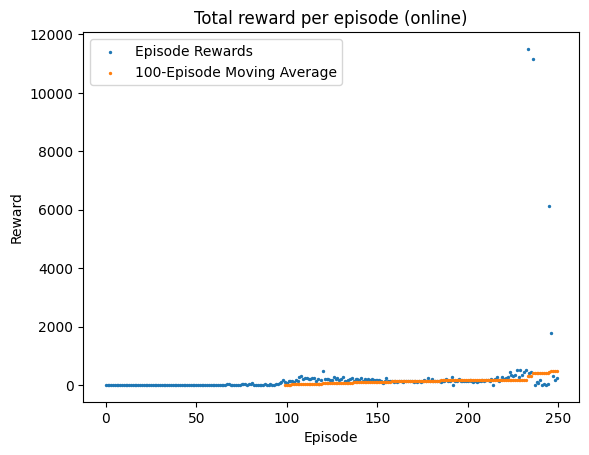

In [26]:
def moving_average(data, window_size=100):
    cumsum = np.cumsum(np.insert(data, 0, 0))
    return (cumsum[window_size:] - cumsum[:-window_size]) / window_size


window_size = 100

trailing_average = moving_average(all_episode_rewards, window_size)

# Plot the original data and the moving average
plt.scatter(np.arange(len(all_episode_rewards)), all_episode_rewards, s=2, label="Episode Rewards")
plt.scatter(np.arange(window_size - 1, len(all_episode_rewards)), trailing_average, s=2, label="100-Episode Moving Average")
plt.title("Total reward per episode (online)")
plt.ylabel("Reward")
plt.xlabel("Episode")
plt.legend()
plt.show()

In [27]:
# env = gym.wrappers.RecordVideo(gym.make("CartPole-v1", render_mode='rgb_array'), f'dqn/cartpole')